## Gaussian Process Fitting

In [1]:
import os
import emcee
import corner
import radvel
import numpy as np
import pandas as pd
import scipy.stats as stats

from tqdm import tqdm
from matplotlib import pyplot as plt
from numpy.linalg import slogdet, solve
from scipy.optimize import newton, minimize, optimize


### Import data

In [150]:
data = pd.read_csv(os.path.join(radvel.DATADIR,'k2-131.txt'), sep=' ')

# Correct HARPS-N velocities to match PFS
avg_velocities = data.groupby('tel')['mnvel'].mean()
offset = avg_velocities['pfs'] - avg_velocities['harps-n']
data.loc[data.tel == 'harps-n', 'mnvel'] += offset

t = np.array(data.time)
vel = np.array(data.mnvel)
errvel = np.array(data.errvel)
tel = np.array(data.tel)

telgrps = data.groupby('tel').groups

instnames = telgrps.keys()

In [151]:
data

,time,mnvel,errvel,tel
0,2.457783e+06,14.013342,3.71,harps-n
1,2.457784e+06,-13.756658,5.95,harps-n
2,2.457784e+06,-2.166658,8.76,harps-n
3,2.457813e+06,24.473342,4.00,harps-n
4,2.457813e+06,24.793342,4.22,harps-n
...,...,...,...,...
65,2.457849e+06,14.370000,4.19,pfs
66,2.457849e+06,23.830000,5.51,pfs
67,2.457849e+06,6.850000,5.44,pfs
68,2.457849e+06,19.560000,5.14,pfs


### Initialise GP kernel

We'll use a quasi-periodic covariance kernel in this fit. An element in the covariance matrix, $C_{ij}$ is defined as follows:

$$
GP(t_i, t_j) = \eta_1^2 exp[-\frac{|t_i-t_j|^2}{\eta_2^2} -\frac{sin^2(\pi|t_i-t_j|/\eta_3)}{2\eta_4^2}] 
$$

$$G(t) \sim N(0, GP(t, t))$$

In [152]:
# define GP kernel
def quasi_periodic_kernel(t, tprime, n1, n2, n3, n4):
    A = -(np.abs(t-tprime)/n2)**2
    B = -(np.sin(np.pi*np.abs(t-tprime)/n3)**2)/(2*n4**2)
    return n1**2 * np.exp(A + B)

### Initilaise Keplerian model

Radial Velcoity equation:
$$RV(t) = K \left[ \cos(v(t) + \omega) + e \cos(\omega) \right] + \gamma$$

where the true anomoly is solved from Keplers equation:

$$v(t) = 2 \arctan \left( \sqrt{\frac{1+e}{1-e}} \tan \left( \frac{E}{2} \right) \right)$$

where $ E - e \sin(E) = M $ and $ M(t) = \frac{2\pi}{P} (t - T_c) $.

In [153]:
# Solve Kepler's equation
def solve_kepler(e, M):
    E = newton(lambda E: E - e * np.sin(E) - M, M)
    return E

# Calculate the RV signal
def keplerian_signal(t, tc, per, secosw, sesinw, K):

    # Eccentricity and omega
    e = np.sqrt(secosw**2 + sesinw**2)
    omega = np.arctan2(sesinw, secosw)

    # Mean anomaly
    M = 2 * np.pi * (t - tc) / per

    # Eccentricity
    E = solve_kepler(e, M)

    # True anomaly
    nu = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2), np.sqrt(1 - e) * np.cos(E / 2))

    return K * (np.cos(nu + omega) + e * np.cos(omega))

Both the GP kerenl and Keplerian model are combined for the model.

$$y(t) = RV(t) + GP(t) + \epsilon(t)$$

### Initialise parameters

Numbers derived from photometry

In [154]:
gp_explength_mean = 9.5*np.sqrt(2.) # sqrt(2)*tau in Dai+ 2017 [days]
gp_explength_unc = 1.0*np.sqrt(2.)
gp_perlength_mean = np.sqrt(1./(2.*3.32)) # sqrt(1/(2*gamma)) in Dai+ 2017
gp_perlength_unc = 0.019
gp_per_mean = 9.64 # T_bar in Dai+ 2017 [days]
gp_per_unc = 0.12

Porb = 0.3693038 # orbital period [days]
Porb_unc = 0.0000091 
Tc = 2457582.9360 # [BJD]
Tc_unc = 0.0011



hyperpraameters for the GP kernel and parameters for the Keplerian model are initialised

In [64]:
# GP hyperparameters
gp_amp = 25.0
gp_explength = gp_explength_mean
gp_per = gp_per_mean
gp_perlength = gp_perlength_mean

gp_params = [gp_amp, gp_explength, gp_per, gp_perlength]

# Keplerian parameters
per1 = Porb
tc1 = Tc
sesinw1 = 0.
secosw1 = 0.
k1 = 6.55
dvdt = 0.
curv = 0.

kepler_params = [per1, tc1, secosw1, sesinw1, k1]

# jitter terms per telescope
jitter_harps_n = 0.5
jitter_pfs = 5.0
jitter_params = {'harps-n':0.5, 'pfs':5.0}

params = per1, tc1, secosw1, sesinw1, k1, gp_amp, gp_explength, gp_per, gp_perlength, jitter_harps_n, jitter_pfs
bounds = [(None, None), (None, None), (0, 0), (0, 0), (0, None), (0, None), (0, None), (0, None), (0, None), (jitter_harps_n, jitter_harps_n), (jitter_pfs, jitter_pfs)]

### Define the model
$$
\mathbf{y} = \mathbf{K}(\mathbf{t}; \theta) + \mathbf{G}(\mathbf{t}; \eta) + \boldsymbol{\epsilon}
$$

Define the likelihood function
$$
p(\mathbf{y} | \mathbf{t}, \theta, \eta) = \frac{1}{\sqrt{(2\pi)^n |\mathbf{\Sigma}|}} \exp\left(-\frac{1}{2} (\mathbf{y} - \mathbf{K}(\mathbf{t}; \theta))^T \mathbf{\Sigma}^{-1} (\mathbf{y} - \mathbf{K}(\mathbf{t}; \theta)) \right)
$$

Define the covariance matrix
$$
\mathbf{\Sigma} = \mathbf{K}_{\text{GP}}(\mathbf{t}, \mathbf{t}; \eta) + \sigma^2 \mathbf{I}
$$

Define the log likelihood
$$
\log p(\mathbf{y} | \mathbf{t}, \theta, \eta) = -\frac{n}{2} \log(2\pi) - \frac{1}{2} \log |\mathbf{\Sigma}| - \frac{1}{2} (\mathbf{y} - \mathbf{K}(\mathbf{t}; \theta))^T \mathbf{\Sigma}^{-1} (\mathbf{y} - \mathbf{K}(\mathbf{t}; \theta))
$$


In [65]:
def log_likelihood(t, vel, errvel, kepler_params, gp_params, jitter_param):
    
    # Keplerian parameters
    per1, tc1, secosw1, sesinw1, k1 = kepler_params

    # GP hyperparameters
    gp_amp, gp_explength, gp_per, gp_perlength = gp_params

    # Keplerian term
    keplerian_term = keplerian_signal(t, tc1, per1, secosw1, sesinw1, k1)

    # Compute the GP covariance matrix
    K = quasi_periodic_kernel(t, t[:, None], gp_amp, gp_explength, gp_per, gp_perlength)

    # Add the jitter term
    total_error = jitter_param**2 + errvel**2
    covariance_matrix = K + np.diag(total_error)

    # Residuals
    residuals = vel - keplerian_term

    # Compute the log determinant and matrix sign
    sign, logdet = slogdet(covariance_matrix)
    if sign <= 0:
        print('Matrix determinant is not positive')
        return -np.inf
    inv_covariance_matrix = solve(covariance_matrix, np.eye(len(t)))
     
    loglike = -0.5 * (np.dot(residuals.T, np.dot(inv_covariance_matrix, residuals)) + logdet + len(t) * np.log(2 * np.pi))

    return loglike

In [66]:
def composite_llike(t, vel, errvel, kepler_params, gp_params, jitter_params):

    total_llike = 0.

    # harps-n
    total_llike += log_likelihood(t[telgrps['harps-n']], vel[telgrps['harps-n']], errvel[telgrps['harps-n']], kepler_params, gp_params, jitter_params['harps-n'])

    # pfs
    total_llike += log_likelihood(t[telgrps['pfs']], vel[telgrps['pfs']], errvel[telgrps['pfs']], kepler_params, gp_params, jitter_params['pfs'])

    return total_llike

In [67]:
composite_llike(t, vel, errvel, kepler_params, gp_params, jitter_params)

-161304.51279532068

### Define Priors

In [102]:
# Period prior
def per_prior(per):
    return stats.norm.pdf(per, Porb, Porb_unc)

# Tc prior
def tc_prior(tc):
    return stats.norm.pdf(tc, Tc, Tc_unc)

# K prior
def k_prior(k):
    if k > 0:
        return -np.log(k)
    else:
        return -np.inf

# GP amplitude prior with bounds
def gp_amp_prior(gp_amp, min_gp_amp=0.01, max_gp_amp=100.0):
    if min_gp_amp < gp_amp < max_gp_amp:
        return -np.log(gp_amp) - np.log(np.log(max_gp_amp/min_gp_amp))
    else:
        return -np.inf
    
# GP explength prior
def gp_explength_prior(gp_explength):
    return stats.norm.pdf(gp_explength, gp_explength_mean, gp_explength_unc)

# GP per prior
def gp_per_prior(gp_per):
    return stats.norm.pdf(gp_per, gp_per_mean, gp_per_unc)

# GP perlength prior
def gp_perlength_prior(gp_perlength):
    return stats.norm.pdf(gp_perlength, gp_perlength_mean, gp_perlength_unc)

# Jitter prior - Jefferies
def jitter_pfs_prior(jitter):
    if jitter > 0:
        return -np.log(jitter)
    else:
        return -np.inf

def jitter_harpsn_prior(jitter):
    if jitter > 0:
        return -np.log(jitter)
    else:
        return -np.inf

### Construct the posterior

In [105]:
def safe_log(x):
    if x > 0:
        return np.log(x)
    else:
        return -np.inf
    
def log_posterior (params):

    # unpack parameters
    per1, tc1, secosw1, sesinw1, k1, gp_amp, gp_explength, gp_per, gp_perlength, jitter_harps_n, jitter_pfs = params

    # fixed parameters
    secosw1 = 0.
    sesinw1 = 0.
    jitter_harps_n = 0.5
    jitter_pfs = 5.0

    # parameters
    kepler_params = [per1, tc1, secosw1, sesinw1, k1]
    gp_params = [gp_amp, gp_explength, gp_per, gp_perlength]
    jitter_param = {'harps-n': jitter_harps_n, 'pfs': jitter_pfs}
    
    # log likelihood
    llike = composite_llike(t, vel, errvel, kepler_params, gp_params, jitter_param)

    # priors
    lprior = 0
    lprior += np.log(per_prior(per1))
    lprior += np.log(tc_prior(tc1))
    lprior += k_prior(k1)
    lprior += gp_amp_prior(gp_amp)
    lprior += np.log(gp_explength_prior(gp_explength))
    lprior += np.log(gp_per_prior(gp_per))
    lprior += np.log(gp_perlength_prior(gp_perlength))
    lprior += jitter_pfs_prior(jitter_pfs)
    lprior += jitter_harpsn_prior(jitter_harps_n)

    # log posterior
    log_posterior = llike + lprior

    if np.isnan(log_posterior):
        return -np.inf
    
    return log_posterior

### Maximum Likelihood Estimation

In [106]:
# Run optimisation
result = minimize(lambda params: -log_posterior(params), params, bounds=bounds, method='Nelder-Mead')

In [107]:
result

 final_simplex: (array([[3.69412683e-01, 2.45758294e+06, 0.00000000e+00, 0.00000000e+00,
        6.54850288e+00, 2.50001851e+01, 1.34360261e+01, 9.63974030e+00,
        4.07416391e-01, 5.00000000e-01, 5.00000000e+00],
       [3.69412725e-01, 2.45758294e+06, 0.00000000e+00, 0.00000000e+00,
        6.54850052e+00, 2.50001854e+01, 1.34360277e+01, 9.63973989e+00,
        4.07416427e-01, 5.00000000e-01, 5.00000000e+00],
       [3.69412579e-01, 2.45758294e+06, 0.00000000e+00, 0.00000000e+00,
        6.54850867e+00, 2.50001844e+01, 1.34360223e+01, 9.63974130e+00,
        4.07416299e-01, 5.00000000e-01, 5.00000000e+00],
       [3.69412682e-01, 2.45758294e+06, 0.00000000e+00, 0.00000000e+00,
        6.54850294e+00, 2.50001851e+01, 1.34360261e+01, 9.63974031e+00,
        4.07416389e-01, 5.00000000e-01, 5.00000000e+00],
       [3.69412736e-01, 2.45758294e+06, 0.00000000e+00, 0.00000000e+00,
        6.54849994e+00, 2.50001855e+01, 1.34360281e+01, 9.63973979e+00,
        4.07416437e-01, 5.00000000e

In [108]:
# Define your parameter names
param_names = ['per1', 'tc1', 'secosw1', 'sesinw1', 'k1', 
               'gp_amp', 'gp_explength', 'gp_per', 'gp_perlength', 'jtt_harps', 'jtt_pfs']

# Results
param_values = result.x

# Create a dictionary from names and values
param_dict = dict(zip(param_names, param_values))

print("Prior posterior: ", log_posterior)
print(param_dict)

Prior posterior:  <function log_posterior at 0x17df02dc0>
{'per1': 0.3694126831895722, 'tc1': 2457582.9381516166, 'secosw1': 0.0, 'sesinw1': 0.0, 'k1': 6.548502875703152, 'gp_amp': 25.000185142608856, 'gp_explength': 13.436026116296274, 'gp_per': 9.639740296971278, 'gp_perlength': 0.4074163905059619, 'jtt_harps': 0.5, 'jtt_pfs': 5.0}


### MCMC Posterior Exploration

In [109]:
# Define the number of walkers, dimensions, and steps
nwalkers, ndim, nsteps = 100, len(param_values), 3000

# Initialize the walkers in a small Gaussian ball around the initial values
starting_guesses = param_values + 1e-4 * np.random.randn(nwalkers, ndim)

# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

# Run the MCMC
sampler.run_mcmc(starting_guesses, nsteps, progress=True)


100%|██████████| 3000/3000 [25:05<00:00,  1.99it/s] 


State([[ 3.69213127e-01  2.45758293e+06  2.25973053e+14 ...  1.12099198e+00
   4.05714503e+13  1.56307067e+14]
 [ 3.69195823e-01  2.45758293e+06  1.29397454e+18 ...  1.12098029e+00
   1.78549797e+17  7.16977892e+17]
 [ 3.69223255e-01  2.45758293e+06  8.14749538e+15 ...  1.12098171e+00
   1.11443826e+15  3.94023827e+15]
 ...
 [ 3.69193904e-01  2.45758293e+06 -1.19836281e+18 ...  1.12095840e+00
  -3.03556194e+17 -1.05534447e+18]
 [ 3.69193039e-01  2.45758293e+06 -1.36473507e+17 ...  1.12079316e+00
   4.37755378e+15  5.61014760e+16]
 [ 3.69188884e-01  2.45758293e+06 -6.25452086e+17 ...  1.12090146e+00
  -1.48396583e+17 -4.95171904e+17]], log_prob=[-57672.08932511 -59613.97822835 -57672.89411246 -57673.50027322
 -59621.67033978 -59614.60309211 -59420.95720399 -59614.62520944
 -59616.74450341 -57678.30850224 -59622.81704529 -59615.81195992
 -59613.41132829 -57675.21294194 -57678.13136576 -57676.76979203
 -59621.33926856 -59617.42074223 -57676.6849393  -59423.33579319
 -59619.02429408 -57677

In [125]:
# Discard burn-in and thin
samples = sampler.get_chain(discard=1000, thin=15, flat=True)

### Trace plot of MCMC chains

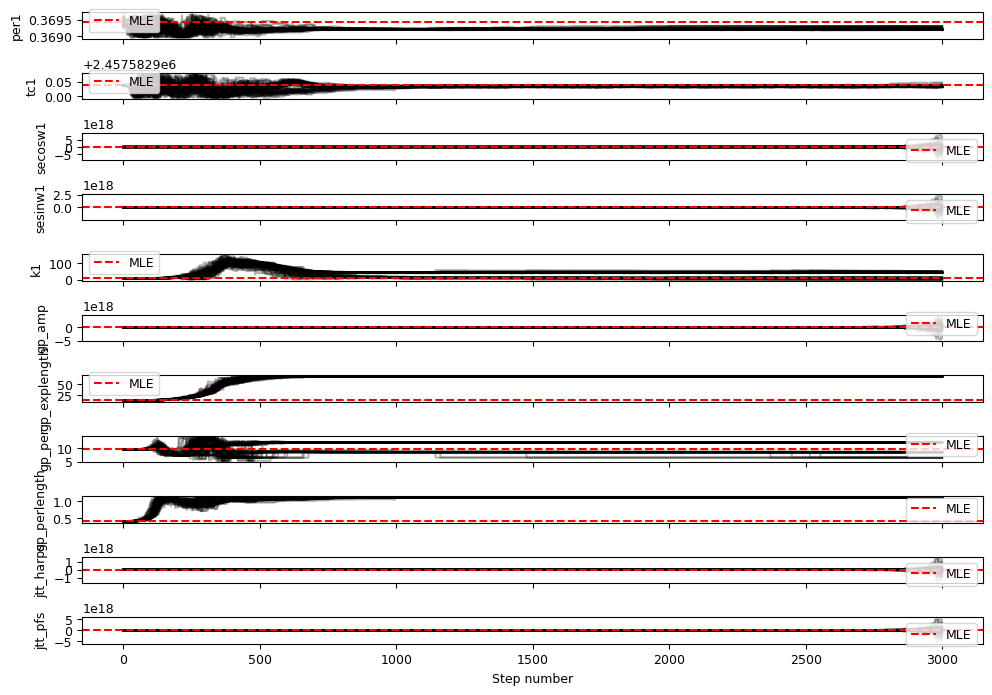

In [126]:
def plot_trace(sampler, params):
    fig, axes = plt.subplots(len(params), figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = params
    for i, param_name in enumerate(labels):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_ylabel(param_name)
        ax.axhline(param_values[i], color='r', linestyle='--', label='MLE')  # Add MLE line
        ax.legend()
        
    axes[-1].set_xlabel("Step number")
    plt.tight_layout()
    plt.show()

plot_trace(sampler, param_names)


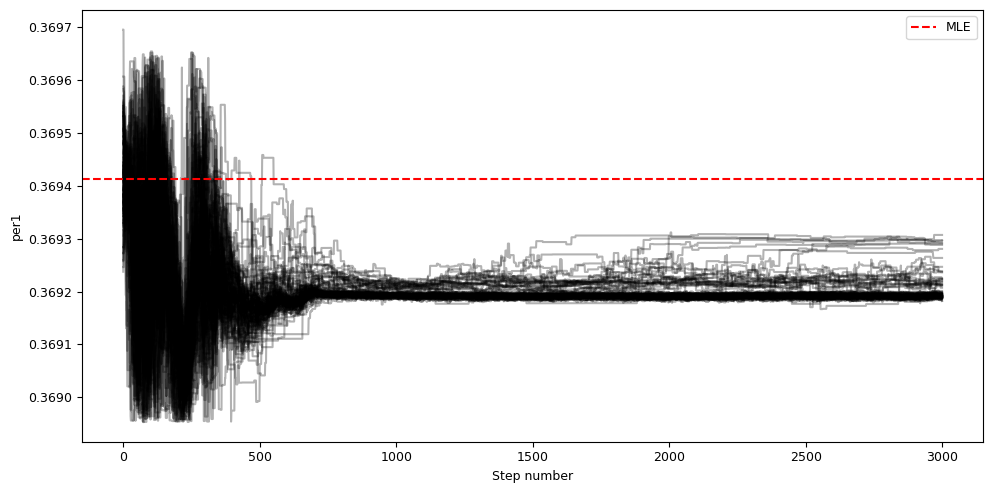

In [127]:
def plot_trace_single_param(sampler, param_name, param_values):
    fig, ax = plt.subplots(figsize=(10, 5))
    samples = sampler.get_chain()
    for walker_index in range(samples.shape[1]):
        ax.plot(samples[:, walker_index, param_names.index(param_name)], "k", alpha=0.3)
    ax.axhline(param_values[param_names.index(param_name)], color='r', linestyle='--', label='MLE')  # Add MLE line
    ax.set_ylabel(param_name)
    ax.set_xlabel("Step number")
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
param_name = 'per1'  # Name of the parameter you want to plot
plot_trace_single_param(sampler, param_name, param_values)

In [128]:
# posterior df
post_df = pd.DataFrame(samples, columns=param_names)
post_df


,per1,tc1,secosw1,sesinw1,k1,gp_amp,gp_explength,gp_per,gp_perlength,jtt_harps,jtt_pfs
0,0.369213,2.457583e+06,-2.801936e+02,-1.935156e+02,10.899445,1.045219e+02,67.938670,12.154130,1.119071,-1.621525e+02,-1.165255e+02
1,0.369194,2.457583e+06,-5.132872e+03,-1.473740e+03,42.713331,2.401074e+03,67.979011,8.605945,1.120994,-1.224722e+03,-3.441445e+03
2,0.369207,2.457583e+06,-3.756042e+02,-2.235385e+02,13.106284,1.461678e+02,67.952420,12.152321,1.119432,-1.910265e+02,-1.610789e+02
3,0.369221,2.457583e+06,-3.678504e+02,-2.209262e+02,11.550031,1.388766e+02,67.974440,12.121528,1.120463,-1.930799e+02,-1.617033e+02
4,0.369193,2.457583e+06,-8.985539e+03,-2.607061e+03,43.003526,4.327684e+03,67.982909,8.601547,1.120923,-1.883530e+03,-5.321611e+03
...,...,...,...,...,...,...,...,...,...,...,...
13295,0.369191,2.457583e+06,-3.817690e+16,-9.302756e+15,43.437892,1.547123e+16,67.988950,8.597352,1.120982,-1.160643e+16,-3.447791e+16
13296,0.369191,2.457583e+06,1.602451e+17,2.769594e+16,44.850811,-7.938741e+16,67.988082,8.599938,1.120990,4.047450e+16,2.143696e+17
13297,0.369194,2.457583e+06,-1.180870e+18,-2.937196e+17,40.871770,5.513547e+17,67.987883,8.593281,1.120930,-2.890946e+17,-9.980647e+17
13298,0.369193,2.457583e+06,-1.070733e+18,-3.037149e+17,40.631924,5.518903e+17,67.985840,8.602866,1.120750,-1.980459e+17,-6.374359e+17


In [129]:
post_df.median()

per1            3.691928e-01
tc1             2.457583e+06
secosw1        -3.045396e+02
sesinw1        -2.094818e+02
k1              4.180849e+01
gp_amp          1.180833e+02
gp_explength    6.798649e+01
gp_per          8.599559e+00
gp_perlength    1.120917e+00
jtt_harps      -1.354600e+02
jtt_pfs        -1.037441e+02
dtype: float64

Pandas support in corner is deprecated; use ArviZ directly


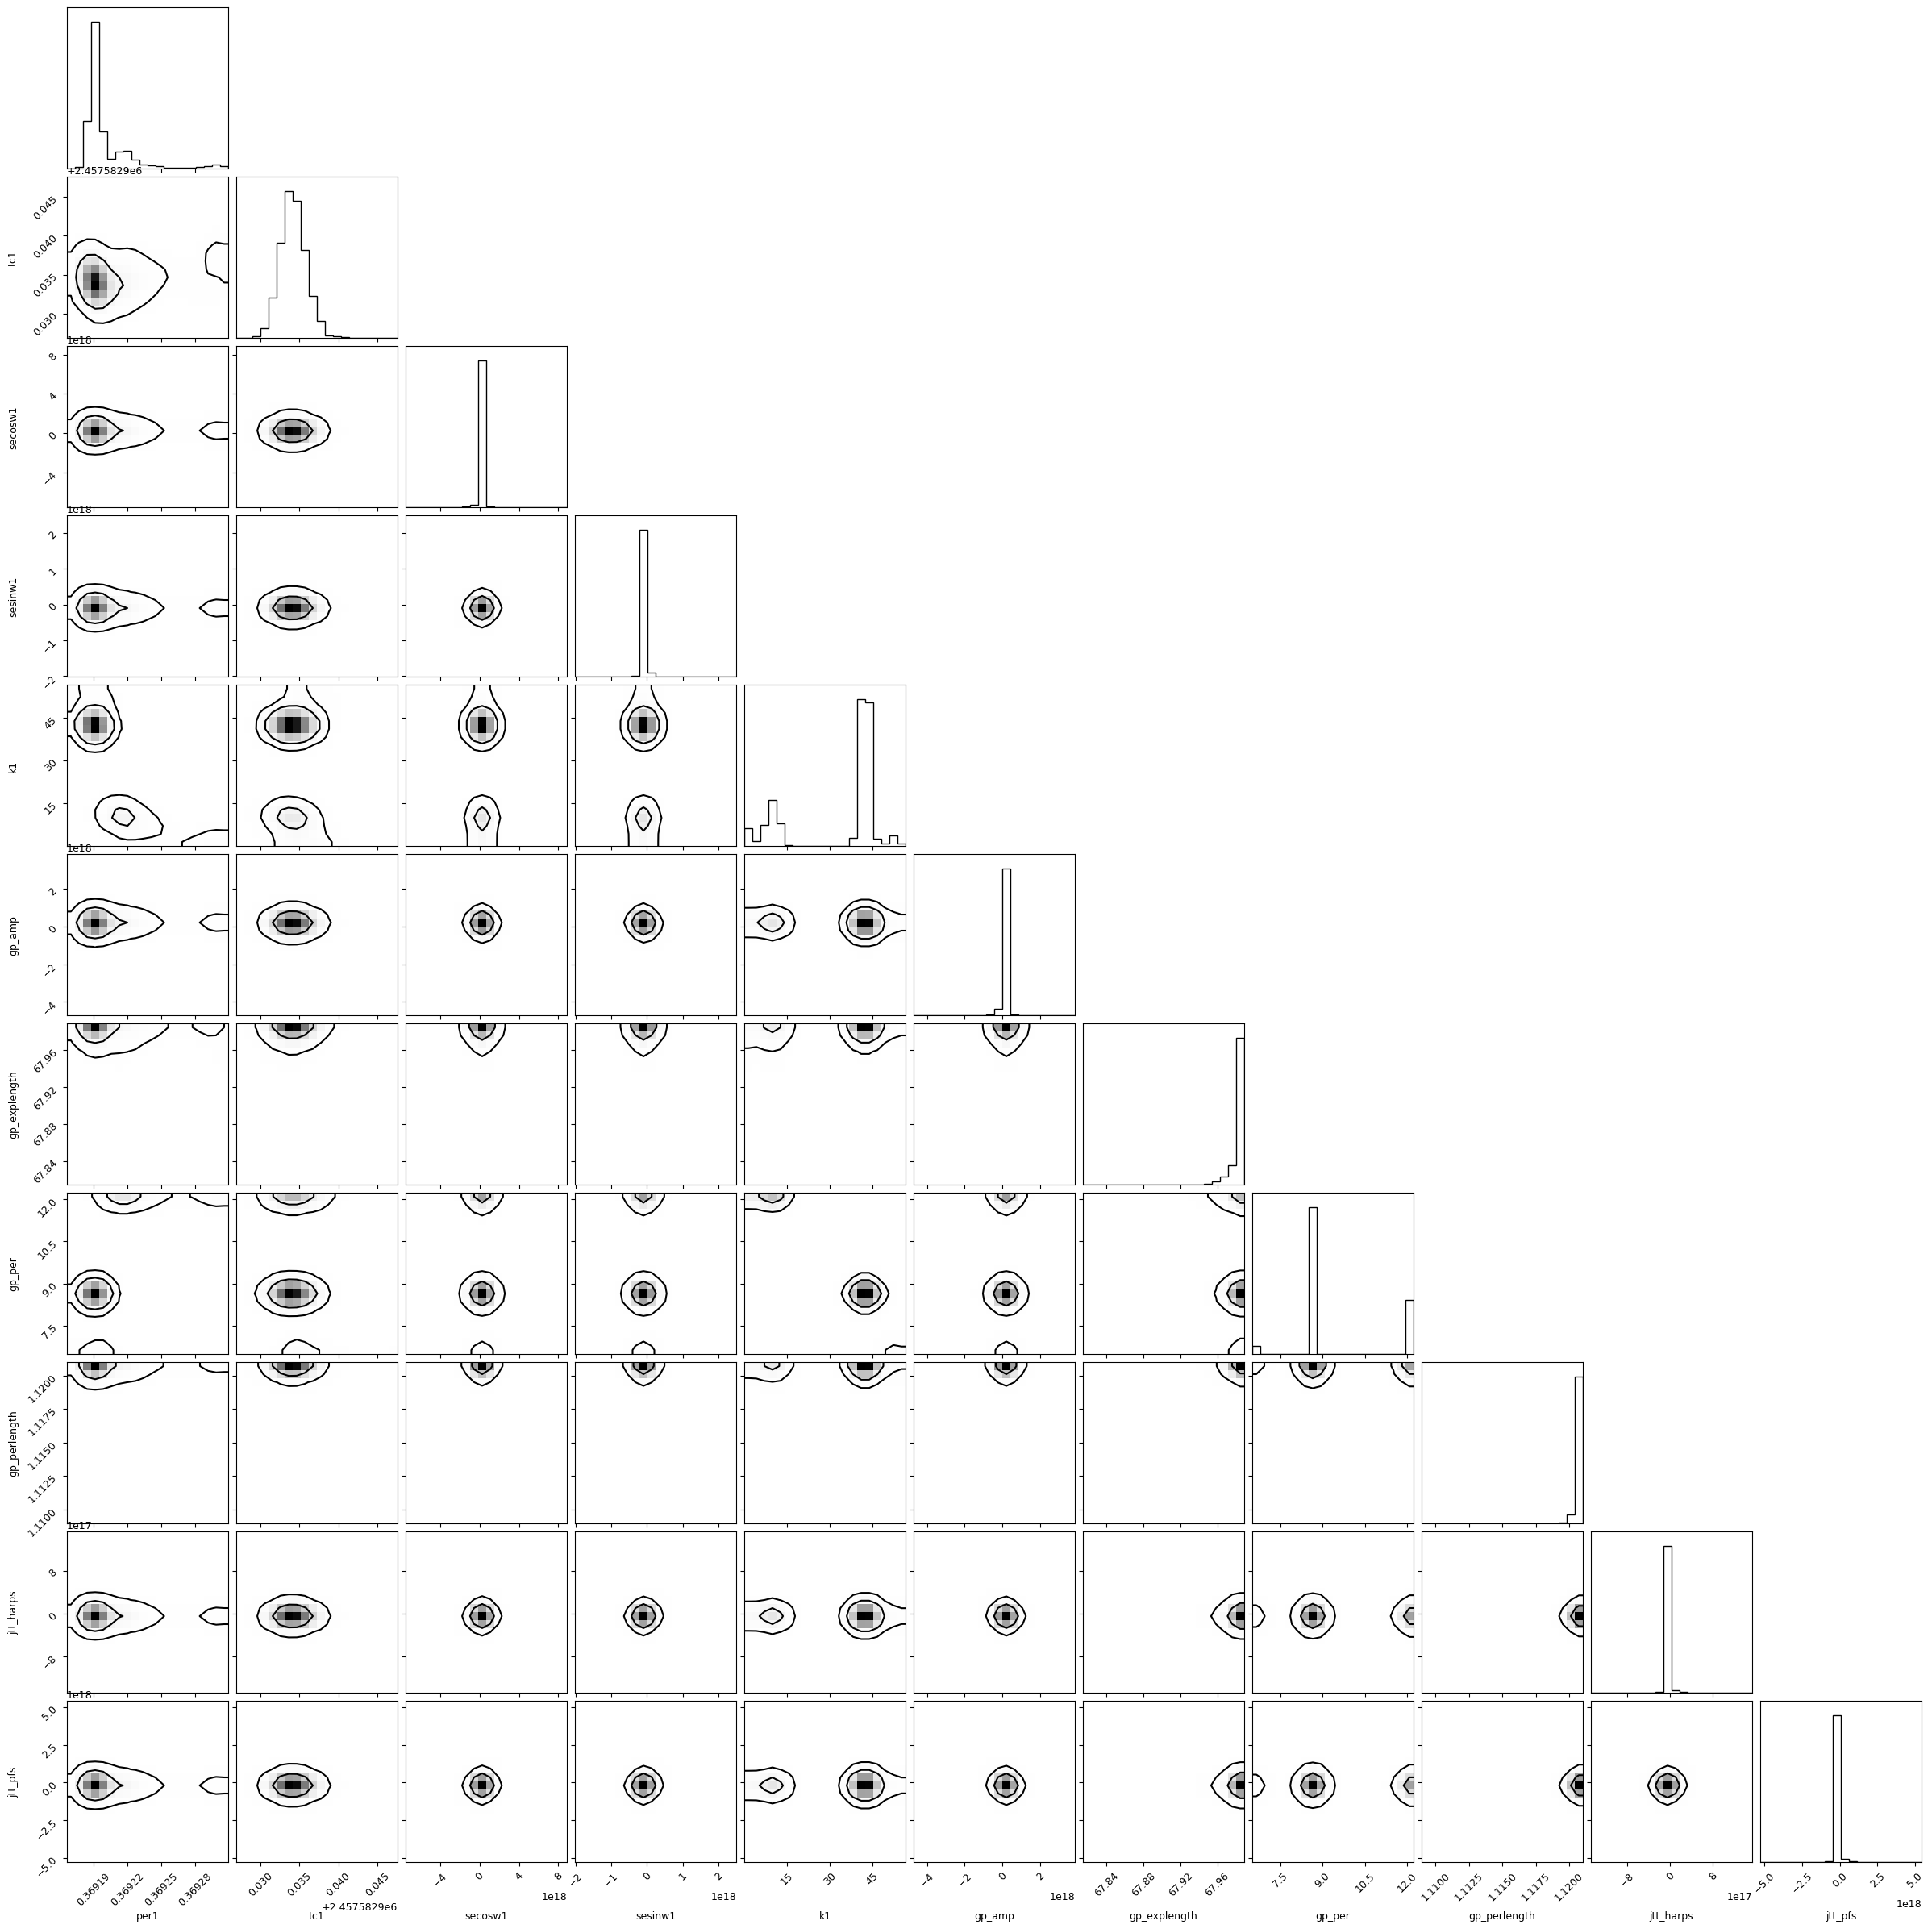

In [130]:
# Selecting labels for the parameters to include in the corner plot
labels = ['per1', 'tc1', 'secosw1', 'sesinw1', 'k1', 'gp_amp', 'gp_explength', 'gp_per', 'gp_perlength', 'jtt_harps', 'jtt_pfs']

fig = corner.corner(
    post_df[labels],  # DataFrame with the parameters
    labels=labels,
    levels=[0.68, 0.95],  
    plot_datapoints=False, 
    smooth=True)
plt.show()  # Show the plot

In [181]:
# Calculate the median values from posterior samples
median_params = post_df.median()
t_model = np.linspace(t.min(), t.max(), 70)

# harps
t_obs_harps = t[telgrps['harps-n']]
rv_obs_harps = vel[telgrps['harps-n']]
rv_err_harps = errvel[telgrps['harps-n']]
# pfs
t_obs_pfs = t[telgrps['pfs']]
rv_obs_pfs = vel[telgrps['pfs']]
rv_err_pfs = errvel[telgrps['pfs']]
# combined
t_obs = t
rv_obs = vel
rv_err = errvel

# RV predictions def keplerian_signal(t, tc, per, secosw, sesinw, K):
rv_predictions = keplerian_signal(t, median_params['tc1'], median_params['per1'], 0, 0, median_params['k1'])
residuals = rv_obs - rv_predictions

# kerenel hyperparams
n1, n2, n3, n4 = median_params['gp_amp'], median_params['gp_explength'], median_params['gp_per'], median_params['gp_perlength']

# covariance matrix
K = np.zeros((len(t), len(t)))
for i in range(len(t)):
    for j in range(len(t)):
        K[i, j] = quasi_periodic_kernel(t[i], t[j], n1, n2, n3, n4)
K += np.diag(errvel**2)

# cross-covariance matrix
K_star = np.zeros((len(t_model), len(t)))
for i in range(len(t_model)):
    for j in range(len(t)):
        K_star[i, j] = quasi_periodic_kernel(t_model[i], t[j], n1, n2, n3, n4)

# GP prediction
K_inv = np.linalg.inv(K)
mu = rv_predictions + K_star @ K_inv @ (rv_obs - rv_predictions)
predictive_std = np.sqrt(np.diag(K_star - K_star @ K_inv @ K_star)) 

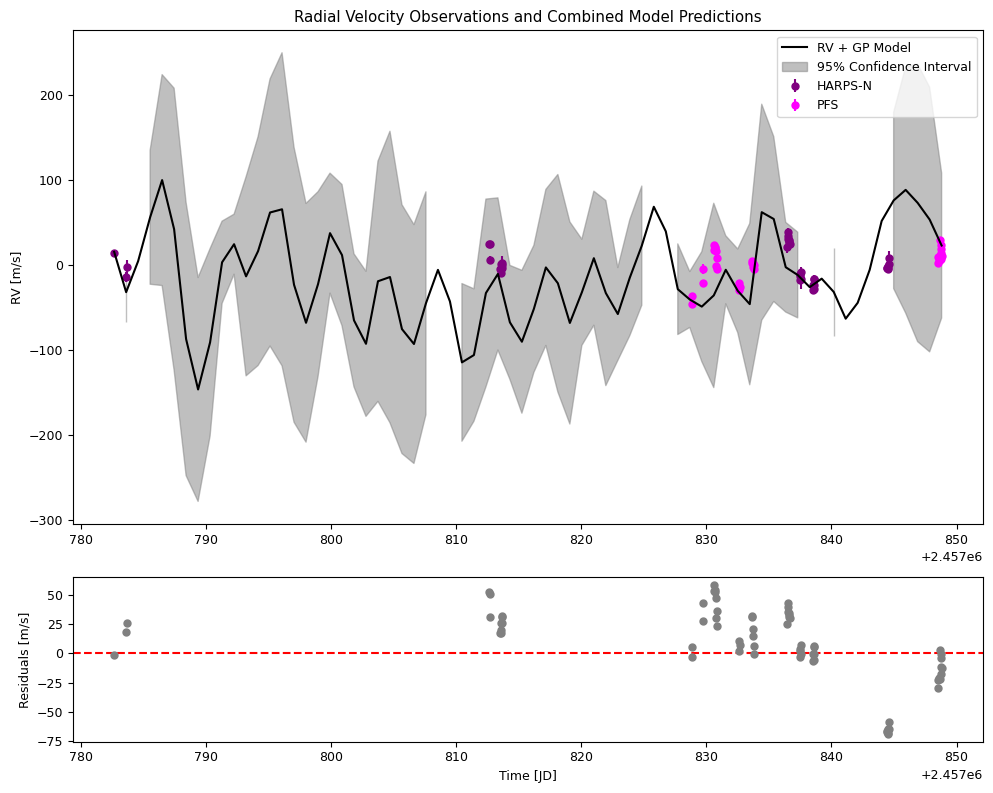

In [180]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Assuming mu has been calculated as shown in the previous messages
# Interpolating model predictions to observation times for residual calculation
interpolator = interp1d(t_model, mu, fill_value="extrapolate")
mu_interpolated = interpolator(t_obs)

# Calculate residuals
rv_residuals = rv_obs - mu_interpolated

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(10, 8))

# Top panel for RV and GP model
ax1.errorbar(t_obs_harps, rv_obs_harps, rv_err_harps, fmt='o', label='HARPS-N', color='purple')
ax1.errorbar(t_obs_pfs, rv_obs_pfs, rv_err_pfs, fmt='o', label='PFS', color='magenta')
ax1.plot(t_model, mu, label='RV + GP Model', color='black', zorder=3)  # Ensure model is on top

# Plot uncertainty band
ax1.fill_between(t_model, mu - 1.96 * predictive_std, mu + 1.96 * predictive_std, color='gray', alpha=0.5, label='95% Confidence Interval')

ax1.set_ylabel('RV [m/s]')
ax1.legend()
ax1.set_title('Radial Velocity Observations and Combined Model Predictions')

# Bottom panel for residuals
ax2.errorbar(t_obs, rv_residuals, fmt='o', color='grey')
ax2.axhline(0, color='red', linestyle='--')
ax2.set_xlabel('Time [JD]')
ax2.set_ylabel('Residuals [m/s]')

plt.tight_layout()
plt.show()


In [184]:
# Calculate phase
phase = ((t_obs - t_obs.min()) % median_params['per1']) / median_params['per1']

df = pd.DataFrame({
    'phase': phase,
    'velocity': rv_obs,
    'error': rv_err,
    'telescope': tel
})

df.sort_values('phase', inplace=True)

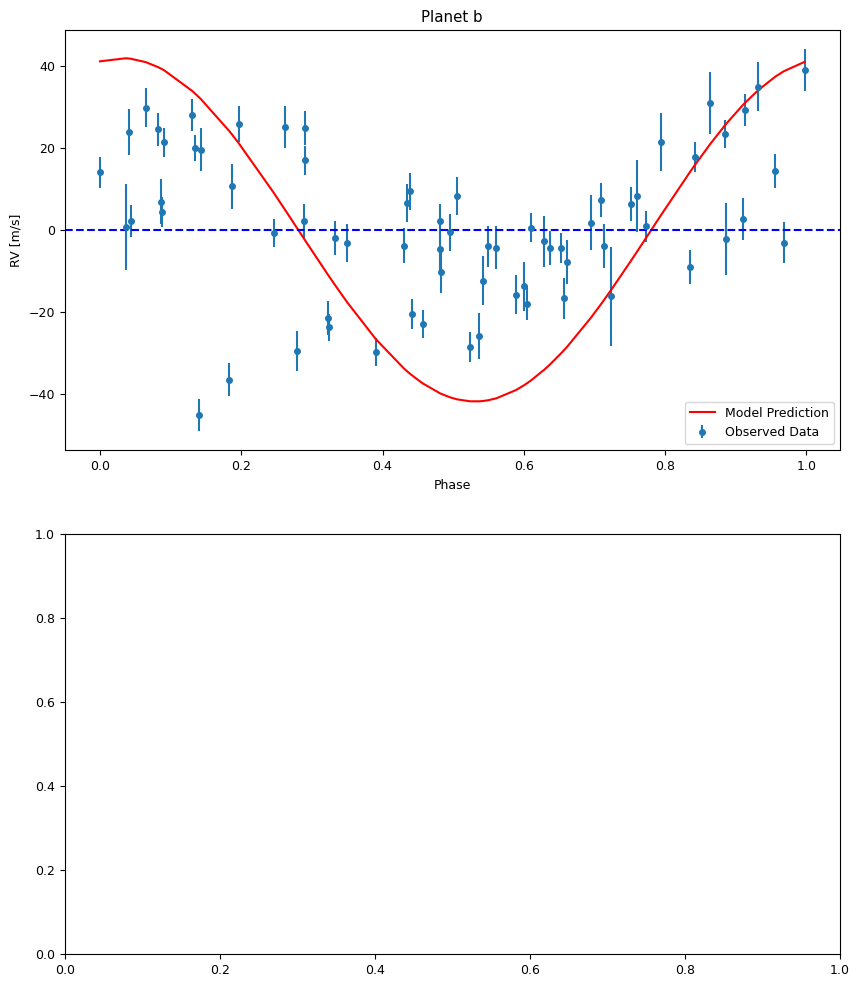

In [190]:
# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot for planet b
ax1.errorbar(phase, rv_obs, yerr=rv_err, fmt='o', label='Observed Data', markersize=4)
ax1.plot(np.sort(phase), rv_predictions[np.argsort(phase)], label='Model Prediction', color='red')
ax1.axhline(0, color='blue', linestyle='--')
ax1.set_title('Planet b')
ax1.set_xlabel('Phase')
ax1.set_ylabel('RV [m/s]')
ax1.legend()
